In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')
fig_dir = os.path.join(os.pardir,os.pardir,'reports','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

In [12]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:52389 Dashboard: http://127.0.0.1:48209/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [127]:
grid_path = os.path.join(data_dir,'preprocessing','processed','waom4_grd.nc')
avg_path = os.path.join(data_dir,'analysis','raw','waom4','ocean_avg_0009.nc')
avg_nt_path = os.path.join(data_dir,'analysis','raw','waom4_nt','ocean_avg_0009.nc')
sector_masks_path = os.path.join(data_dir,'analysis','interim','mask_sector_4.npy') 
grd4 = xr.open_dataset(grid_path)
avg4= xr.open_dataset(avg_path)
avg4_nt= xr.open_dataset(avg_nt_path)
sector4 = np.load(sector_masks_path).item()

In [2]:
grid_path = os.path.join(data_dir,'preprocessing','processed','waom2_grd.nc')
u_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_u_avg.nc')
v_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_v_avg.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
sector_masks_path = os.path.join(data_dir,'analysis','interim','mask_sector_2.npy') 

grd2 = xr.open_dataset(grid_path)
u2 = xr.open_dataset(u_path).u
v2 = xr.open_dataset(v_path).v
temp2 = xr.open_dataset(temp_path).temp
salt2 = xr.open_dataset(salt_path).salt
m2 = xr.open_dataset(m_path).m
sector2 = np.load(sector_masks_path).item()

In [4]:
a0,a1,a2,a3 = (3.5803e-5, 8.5258e-6, -6.8360e-8, 6.6228e-10)
a3

SyntaxError: invalid syntax (<ipython-input-4-60c11c6fa105>, line 1)

In [ ]:
def dTemp(Sal,Temp,Pres)
'''Calculates from the salinity (Sal,psu), the in-situ Temperature
 (Temp, degC) and the in-situ pressure (Pres, dbar) the adiabatic 
 temperature gradient (dTemp, K Dbar^-1).

 Check values: dTemp  =     3.255976E-4 K dbar^-1
#          given Sal    =    40.0         psu
#                Temp   =    40.0         degC
#                Pres   = 10000.000       dbar
''' 
    s0=35.0
    a0,a1,a2,a3 = (3.5803e-5, 8.5258e-6, -6.8360e-8, 6.6228e-10)
    b0,b1 = (1.8932e-6, -4.2393e-8)
    c0,c1,c2,c3 = (1.8741e-8, -6.7795e-10, 8.7330e-12, -5.4481e-14)
    d0,d1  = (-1.1351e-10, 2.7759e-12)
    e0,e1,e2 = (-4.6206e-13,  1.8676e-14, -2.1687e-16)
    ds = Sal-s0





    return dTemp

In [17]:
Cd=5.0e-3
s2a = 3600*24*365.25
def calc_ustar(u,v,mask):
    u = u.isel(s_rho=30).mean('ocean_time').values
    v = v.isel(s_rho=30).mean('ocean_time').values
    # Interpolate u to the rho-grid
    w_bdry_u = u[:,0]
    middle_u = 0.5*(u[:,0:-1] + u[:,1:])
    e_bdry_u = u[:,-1]
    u_rho = np.concatenate((w_bdry_u[:,None], middle_u, e_bdry_u[:,None]), axis=1)
    # Interplate v to the rho-grid
    s_bdry_v = v[0,:]
    middle_v = 0.5*(v[0:-1,:] + v[1:,:])
    n_bdry_v = v[-1,:]
    v_rho = np.concatenate((s_bdry_v[None,:], middle_v, n_bdry_v[None,:]), axis=0)
    
    mag = np.sqrt(u_rho**2+v_rho**2)
    ustar = Cd*mag
    return xr.DataArray(ustar,dims=('eta_rho','xi_rho')).where(mask)

def calc_Tstar(salt,temp,zice,mask):
    a = -0.057
    b = 0.0939
    c = 7.61e-4

    Sm = salt.isel(s_rho=30).mean('ocean_time').values
    TFb = a*Sm + b + c*zice
    Tstar = (temp.isel(s_rho=30).mean('ocean_time').values - TFb)
    return xr.DataArray(Tstar,dims=('eta_rho','xi_rho')).where(mask)

In [146]:
mask4=((grd4.mask_rho==1) & (grd4.zice < 0.0))

ustar4 = calc_ustar(avg4.u,avg4.v,mask4)
Tstar4 = calc_Tstar(avg4.salt,avg4.temp,grd4.zice,mask4)
mstar4 = avg4.m.where(mask4).mean('ocean_time')

ustar4nt = calc_ustar(avg4_nt.u,avg4_nt.v,mask4)
Tstar4nt = calc_Tstar(avg4_nt.salt,avg4_nt.temp,grd4.zice,mask4)
mstar4nt = avg4_nt.m.where(mask4).mean('ocean_time')

In [4]:
mask2=((grd2.mask_rho==1) & (grd2.zice < 0.0))

ustar2 = calc_ustar(u2,v2,mask2)
Tstar2 = calc_Tstar(salt2,temp2,grd2.zice,mask2)
mstar2 = m2.where(mask2).mean('ocean_time')

NameError: name 'Cd' is not defined

In [150]:
def get_fit(x,y):
    fit = np.polyfit(x[x>0],y[x>0],1)
    return np.poly1d(fit)

In [268]:
def plot_star(x4in,x4ntin,x2in,xlim,ylim,xlabel,out_path=False):
    plt.close()
    fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(14,12))

    for ax,(sec_name,sec_mask) in log_progress(zip(axes.flatten(),sector4.items()),every=2):

        mask4sec = sec_mask & mask4
        y4 = mstar4.values[mask4sec]*s2a
        x4 = x4in.values[mask4sec]
        fit4 = get_fit(x4,y4)

        y4nt = mstar4nt.values[mask4sec]*s2a
        x4nt = x4ntin.values[mask4sec]
        fit4nt = get_fit(x4nt,y4nt)

        mask2sec = sector2[sec_name] & mask2
        y2 = mstar2.values[mask2sec]*s2a
        x2 = x2in.values[mask2sec]
        fit2 = get_fit(x2,y2)

        ax.plot(x2,y2,'r.',alpha=1,markersize=1)
        ax.plot(x2,fit2(x2),'r-',alpha=1,label='2km')

        ax.plot(x4,y4,'b.',alpha=1,markersize=1)
        ax.plot(x4,fit4(x4),'b-',alpha=1,label='4km')

        ax.plot(x4nt,y4nt,'g.',alpha=1,markersize=1)
        ax.plot(x4nt,fit4nt(x4nt),'g-',alpha=1,label=' 4km no tides')

        ax.set_title(sec_name)

        for ax in axes.flatten():
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

        for ax in axes.flatten()[6:]:
            ax.set_xlabel(xlabel)
        for ax in axes.flatten()[[0,3,6]]:
            ax.set_ylabel('Ice shelf melting (m/yr)')

    axes[0,2].legend()
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path,dpi=300,bbox_to_anchor='tight')
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


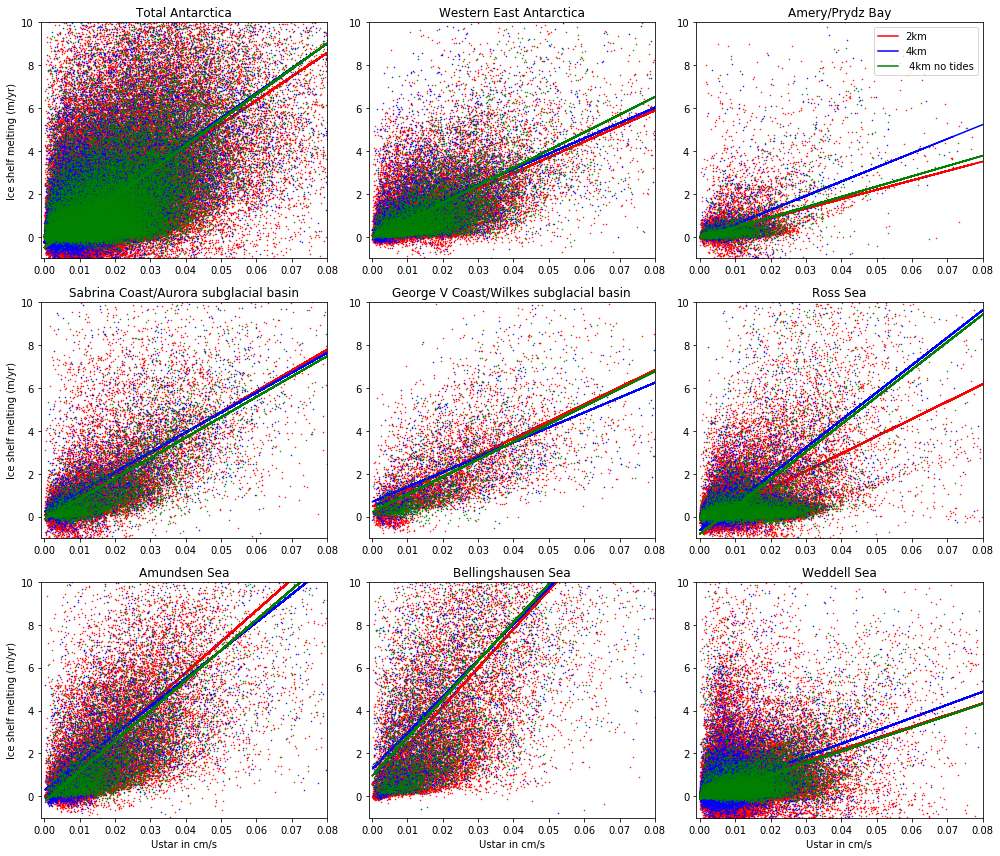

In [269]:
plot_star(ustar4*100,ustar4nt*100,ustar2*100,[-0.001,0.08],[-1,10],'Ustar in cm/s',
         os.path.join(fig_dir,'tmp','ustar.png'))

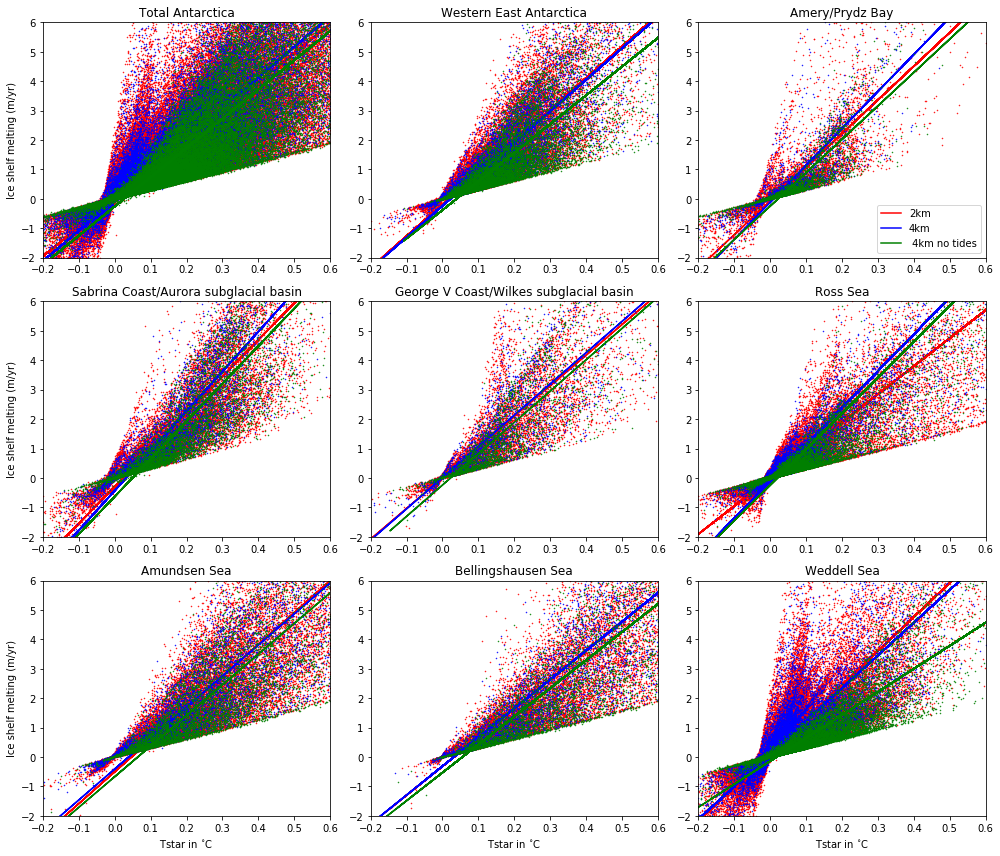

In [240]:
plot_star(Tstar4,Tstar4nt,Tstar2,[-0.2,0.6],[-2,6],'Tstar in $^{\circ}$C',
         os.path.join(fig_dir,'tmp','Tstar.png'))

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


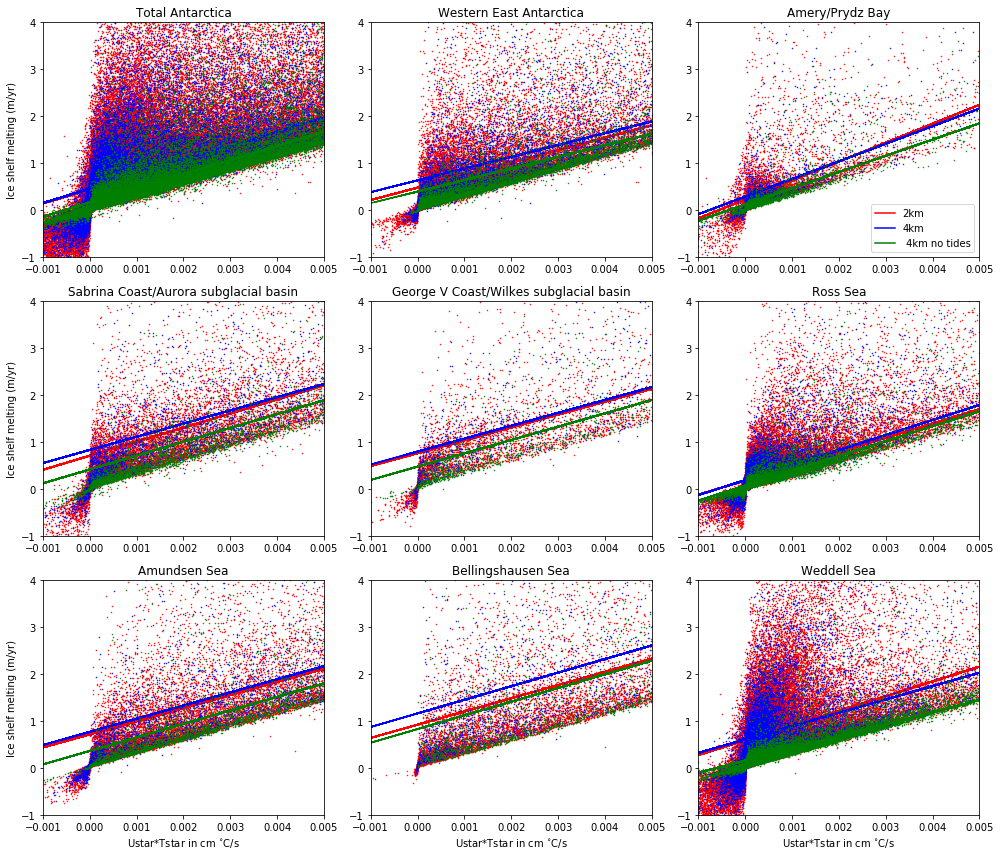

In [272]:
plot_star(ustar4*100*Tstar4,ustar4nt*100*Tstar4nt,ustar2*100*Tstar2,[-0.001,0.005],[-1,4],'Ustar*Tstar in cm $^{\circ}$C/s',
os.path.join(fig_dir,'tmp','ustarTstar.png'))

In [231]:
def plot_star_map(star,levels,label,cmap,out_path=False):


    plt.close()
    fig,ax = plt.subplots(figsize=(14,10'Tstar in $^{\circ}$C'))
    ax.contourf(grd4.mask_rho.where(grd4.mask_rho==0),colors=(('0.6','0.6','0.6')))
    img = star.plot.contourf(ax=ax,levels=levels,add_colorbar=False,cmap=cmap)
    plt.colorbar(img,ax=ax,label=label)
    for k,sec_mask in sector4.items():
            sec_mask.where((grd.mask_rho ==1)&(grd.zice==0.0)).plot.contour(colors=('black'),linewidths=0.1,ax=ax) 
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300,bbox_to_anchor='tight')
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


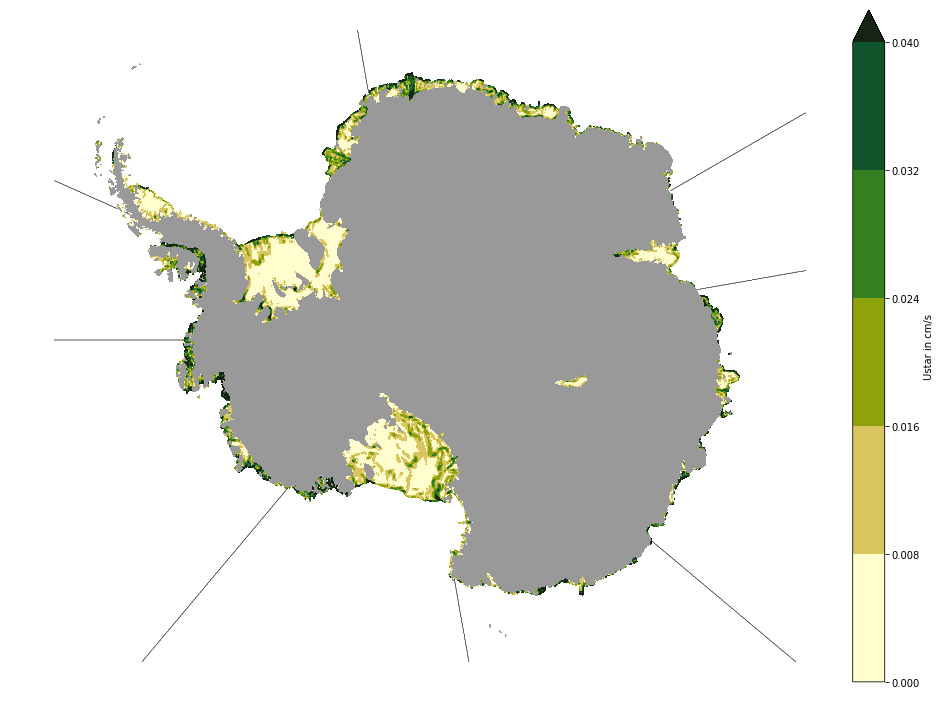

In [244]:
plot_star_map(ustar4*100,np.linspace(0,0.04,6),'Ustar in cm/s',ocm.speed,
         os.path.join(fig_dir,'tmp','ustar_map.png'))

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


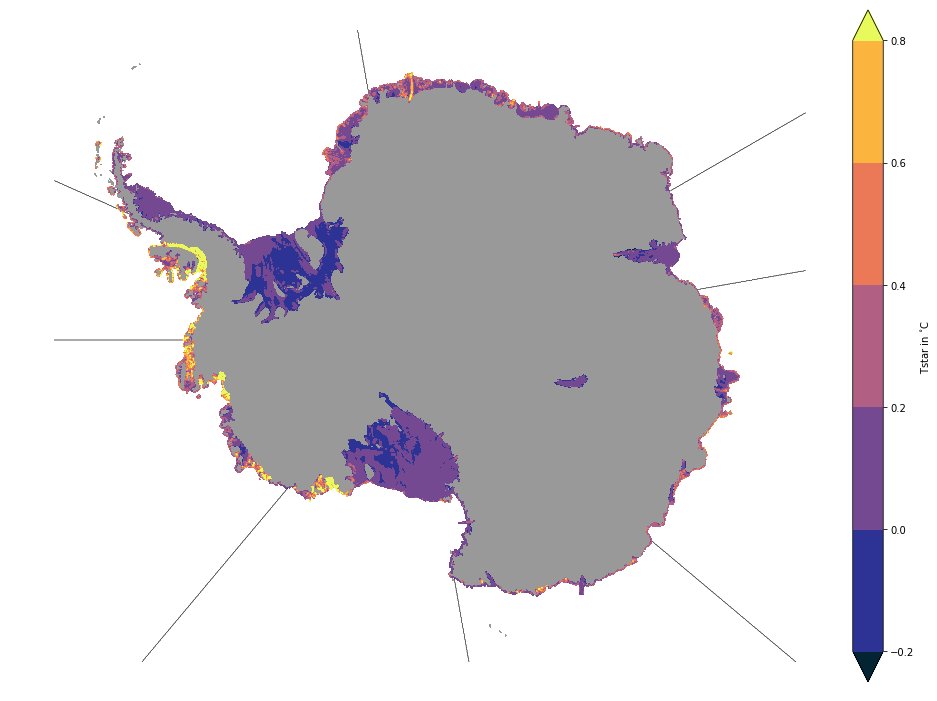

In [245]:
plot_star_map(Tstar4,np.linspace(-0.2,0.8,6),'Tstar in $^{\circ}$C',ocm.thermal,
         os.path.join(fig_dir,'tmp','Tstar_map.png'))

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


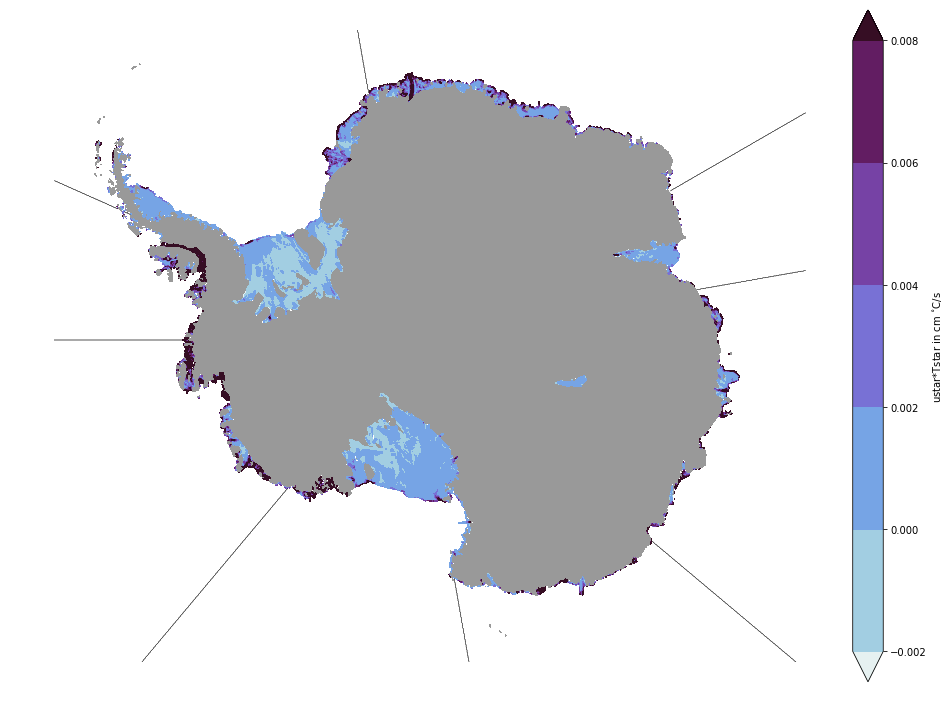

In [263]:
plot_star_map(Tstar4*ustar4*100,np.linspace(-0.002,0.008,6),'ustar*Tstar in cm $^{\circ}$C/s',ocm.dense,
         os.path.join(fig_dir,'tmp','ustrTstar_map.png'))

In [6]:
shelves_path = os.path.join(data_dir,'analysis','interim','shelves2.npy')
shelves = np.load(shelves_path).item()

In [12]:
test = dict((k, shelves[k]) for k in ('Abbot', 'Ronne', 'Amery'))

In [35]:
for shelf_name,shelf_data in log_progress(shelves.items(),every=2):
    mask = shelf_data['mask']
    shelves[shelf_name]['ustar']=calc_ustar(u2,v2,mask).mean()
    shelves[shelf_name]['tstar']=calc_Tstar(salt2,temp2,grd2.zice,mask).mean()
    shelves[shelf_name]['mstar']=m2.where(mask).mean()

In [91]:
import pandas as pd
melt = pd.read_csv(os.path.join(proj_dir,'reports','tables','2km_mass_loss_all.csv'),index_col=0)
melt.loc['Pine Island']['A']

5.688085712174944

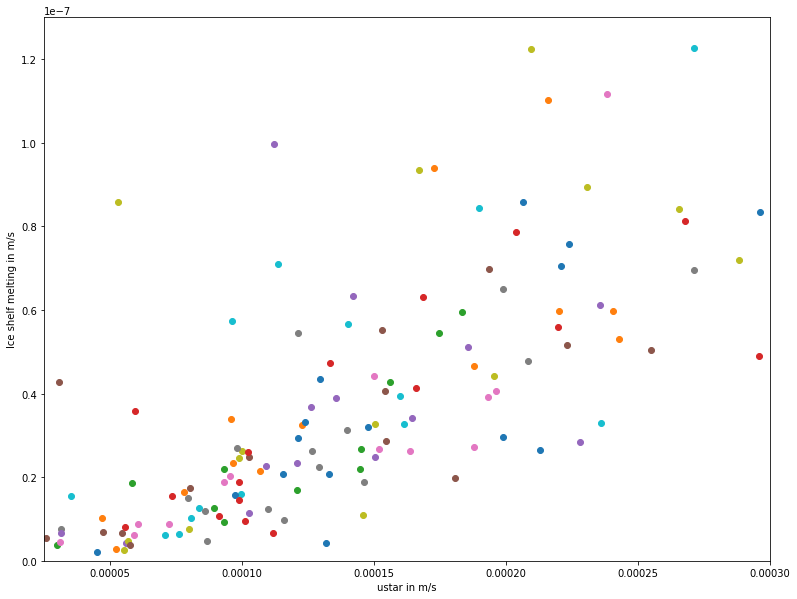

In [138]:
%matplotlib inline
plt.close()
fig,ax = plt.subplots(figsize=(13,10))
for name,data in shelves.items():
    x = data['ustar'].values
    y = data['mstar'].values
    if np.isnan([x,y]).any():
        #print(name+' out due to nan')
        continue
    #if melt.loc[name]['A'] < 5: 
        #print(name+' out due to small')
     #   continue
    #print(name,x,y)
    ax.scatter(x, y)
    #ax.annotate(name,(x,y))
ax.set_ylabel('Ice shelf melting in m/s')
ax.set_xlabel('ustar in m/s')
ax.set_xlim((0.000025,0.0003))
ax.set_ylim((0,0.00000013))
plt.savefig(os.path.join(fig_dir,'tmp','ustar_is_all'),dpi=300,bbox_to_anchor='tight')
plt.show()

In [63]:
x=3
y=np.nan
np.isnan([x,y]).any()

True

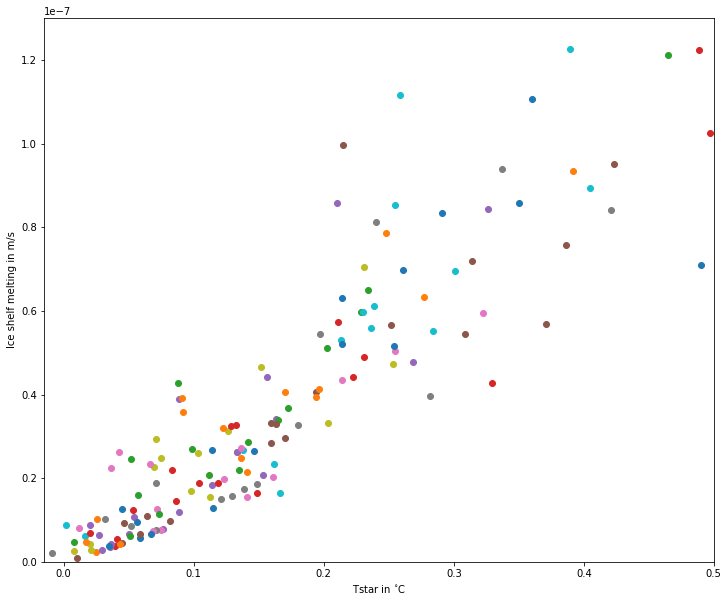

In [136]:
%matplotlib inline
plt.close()
fig,ax = plt.subplots(figsize=(12,10))
for name,data in shelves.items():
    x = data['tstar']
    y = data['mstar']
    if np.isnan([x,y]).any():
        #print(name+' out due to nan')
        continue
    #if melt.loc[name]['A'] < 5: 
        #print(name+' out due to small')
     #   continue
    #print(name,x,y)
    ax.scatter(x, y)
    #ax.annotate(name,(x,y))
ax.set_ylabel('Ice shelf melting in m/s')
ax.set_xlabel('Tstar in $^{\circ}$C')
ax.set_xlim((-0.015,0.5))
ax.set_ylim((0,0.00000013))
plt.savefig(os.path.join(fig_dir,'tmp','tstar_is_all'),dpi=300,bbox_to_anchor='tight')
plt.show()

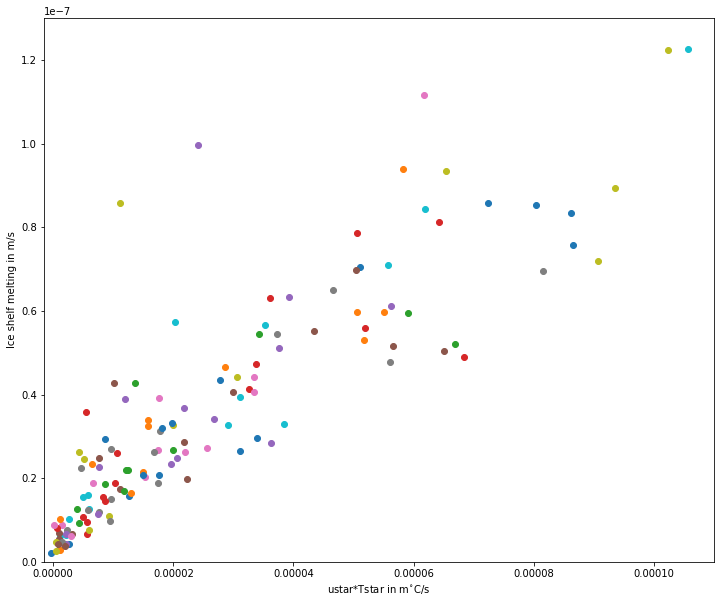

In [139]:
plt.close()
fig,ax = plt.subplots(figsize=(12,10))
for name,data in shelves.items():
    x = data['tstar']*data['ustar']
    y = data['mstar']
    if np.isnan([x,y]).any():
        #print(name+' out due to nan')
        continue
    #if melt.loc[name]['A'] < 5: 
        #print(name+' out due to small')
     #   continue
    #print(name,x,y)
    ax.scatter(x, y)
    #ax.annotate(name,(x,y))
ax.set_ylabel('Ice shelf melting in m/s')
ax.set_xlabel('ustar*Tstar in m$^{\circ}$C/s')
ax.set_xlim((-0.0000015,0.00011))
ax.set_ylim((0,0.00000013))
plt.savefig(os.path.join(fig_dir,'tmp','ustarTstar_is_all'),dpi=300,bbox_to_anchor='tight')
plt.show()

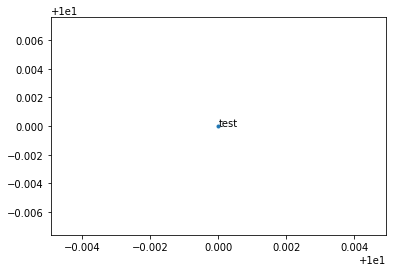

In [31]:
plt.close()
plt.scatter(10,10,marker='.')
plt.annotate('test',(10,10))
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


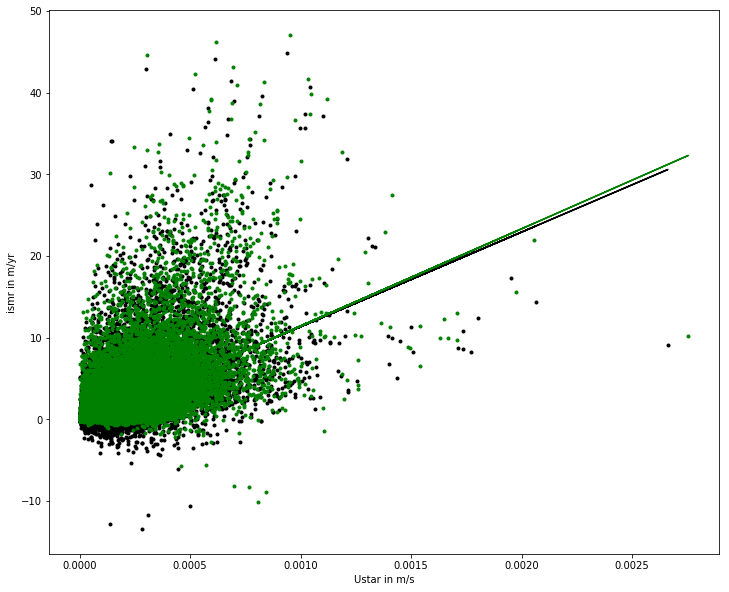

In [124]:
plot_star(ustar,ustar_nt,m,m_nt,'Ustar in m/s')

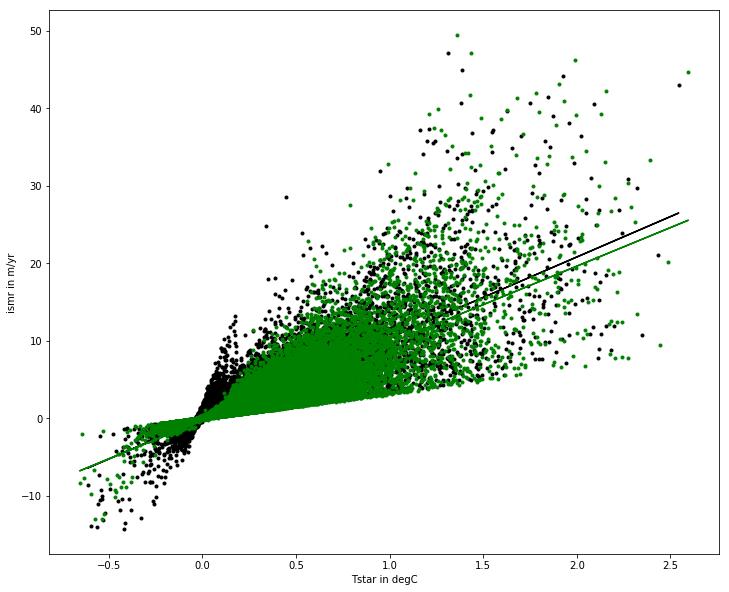

In [125]:
plot_star(Tstar,Tstar_nt,m,m_nt,'Tstar in degC')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


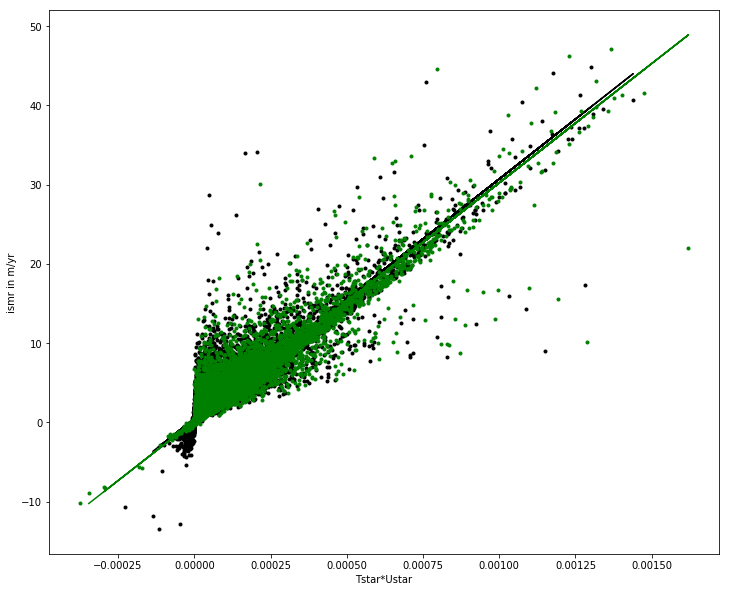

In [126]:
plot_star(Tstar*ustar,Tstar_nt*ustar_nt,m,m_nt,'Tstar*Ustar')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


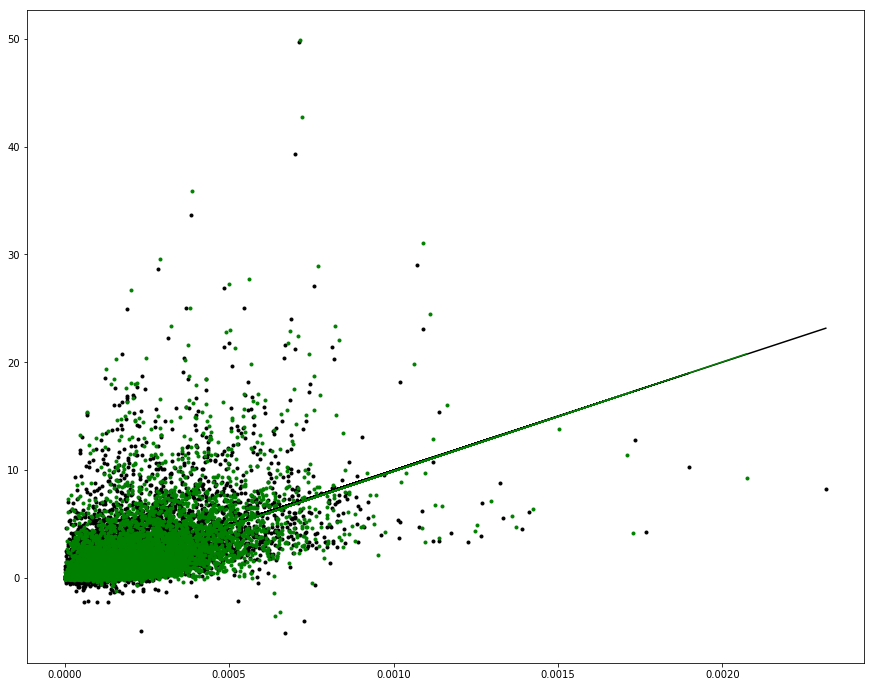

In [108]:
from scipy.stats import linregress

s2a = 3600*24*365.25
mask = (grd.mask_rho==1) & (grd.zice < 0.0)

y = m.values[mask]*s2a
x = ustar.values[mask]
fit = np.polyfit(x[x>0],y[x>0],1)
fit_fn = np.poly1d(fit) 
y2 = m_nt.values[mask]*s2a
x2 = ustar_nt.values[mask]
fit2 = np.polyfit(x2[x2>0],y2[x2>0],1)
fit_fn2 = np.poly1d(fit2)

plt.close()
fig,ax = plt.subplots(figsize=(15,12))
plt.plot(x,y,'k.',x,fit_fn(x),'k-',x2,y2,'g.',x2,fit_fn2(x2),'g-')
#plt.savefig(os.path.join(fig_dir,'ismr_vs_depth.png'),transparent=True,dpi=300)
plt.show()

In [105]:
fit

array([ 1.01503973e+04, -2.68975278e-01])

In [107]:
fit2

array([ 1.01503973e+04, -2.68975278e-01])

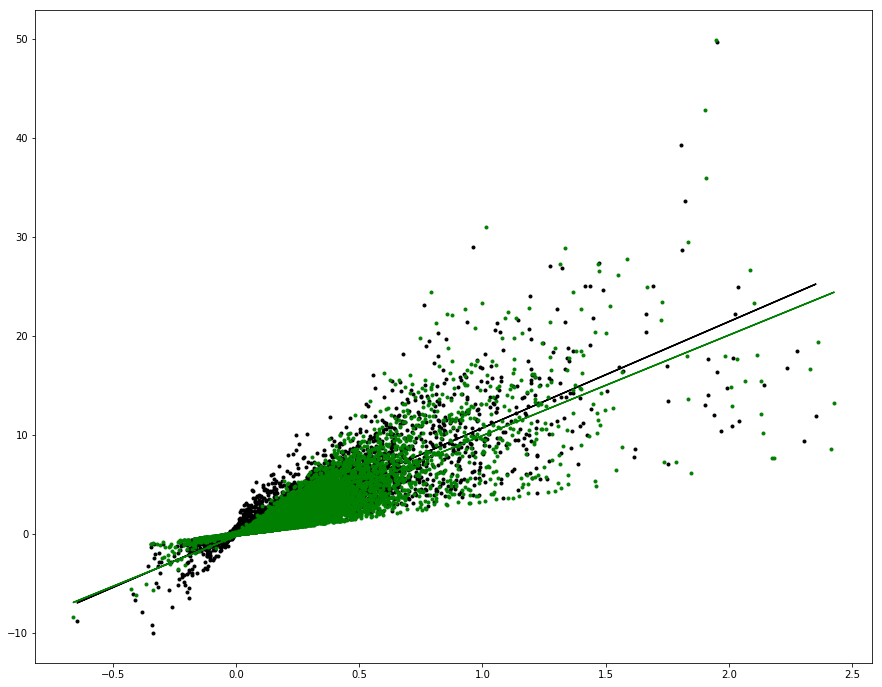

In [109]:
x = Tstar.values[mask]
fit = np.polyfit(x[x>0],y[x>0],1)
fit_fn = np.poly1d(fit) 
x2 = Tstar_nt.values[mask]
fit2 = np.polyfit(x2[x2>0],y2[x2>0],1)
fit_fn2 = np.poly1d(fit2)

plt.close()
fig,ax = plt.subplots(figsize=(15,12))
plt.plot(x,y,'k.',x,fit_fn(x),'k-',x2,y2,'g.',x2,fit_fn2(x2),'g-')
#plt.savefig(os.path.join(fig_dir,'ismr_vs_depth.png'),transparent=True,dpi=300)
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


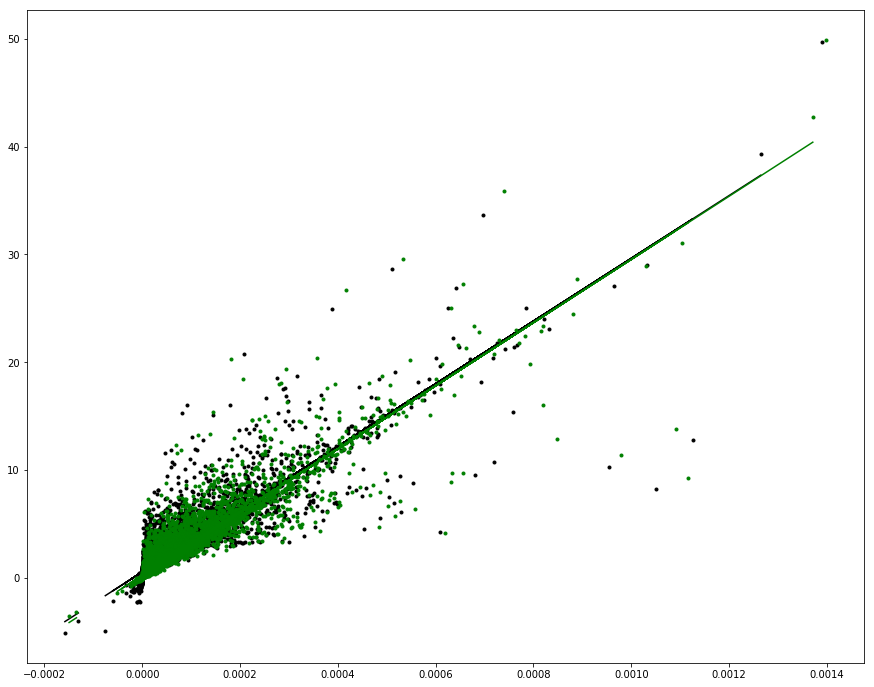

In [110]:
x = (Tstar*ustar).values[mask]
fit = np.polyfit(x[x>0],y[x>0],1)
fit_fn = np.poly1d(fit) 
x2 = (Tstar_nt*ustar_nt).values[mask]
fit2 = np.polyfit(x2[x2>0],y2[x2>0],1)
fit_fn2 = np.poly1d(fit2)

plt.close()
fig,ax = plt.subplots(figsize=(15,12))
plt.plot(x,y,'k.',x,fit_fn(x),'k-',x2,y2,'g.',x2,fit_fn2(x2),'g-')
#plt.savefig(os.path.join(fig_dir,'ismr_vs_depth.png'),transparent=True,dpi=300)
plt.show()

In [86]:
linregress?

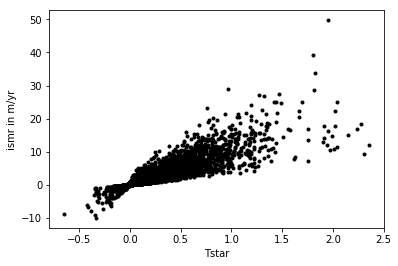

In [59]:
s2a = 3600*24*365.25
mask = (grd.mask_rho==1) & (grd.zice < 0.0)
y = m.values[mask]*s2a
x = Tstar.values[mask]
plt.close()
fig,ax = plt.subplots()
plt.plot(x,y,'k.')
plt.xlabel('Tstar')
plt.ylabel('ismr in m/yr')
#plt.savefig(os.path.join(fig_dir,'ismr_vs_depth.png'),transparent=True,dpi=300)
plt.show()

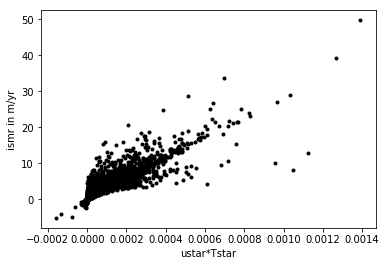

In [60]:
s2a = 3600*24*365.25
mask = (grd.mask_rho==1) & (grd.zice < 0.0)
y = m.values[mask]*s2a
x = (ustar*Tstar).values[mask]
plt.close()
fig,ax = plt.subplots()
plt.plot(x,y,'k.')
plt.xlabel('ustar*Tstar')
plt.ylabel('ismr in m/yr')
#plt.savefig(os.path.join(fig_dir,'ismr_vs_depth.png'),transparent=True,dpi=300)
plt.show()